## Parks Data

### 1. Data Preprocessing

In [52]:
# Load list of relevant parks
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Load overall park geoJSON file and adjust datetype of merge condition to integer
gjson_df = gpd.read_file('./data/parks.json')
gjson_df["idnr"] = gjson_df["idnr"].astype('int64')

# Load list of relevant park ids
df = pd.read_csv('./data/relevant_ids.csv', sep = ';')

<AxesSubplot: >

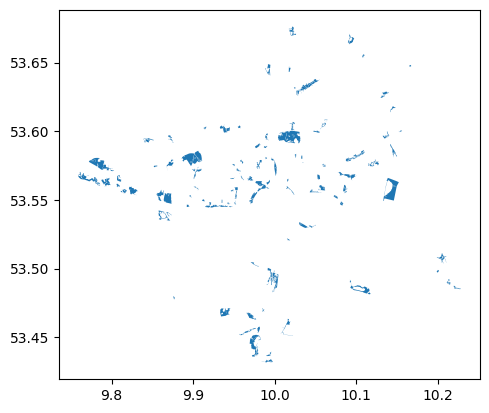

In [43]:
# Merge both dataframes to have basic dataset of all relevant park polygons
merged_gdf = gpd.GeoDataFrame(gjson_df.merge(df, on='idnr'))

# Plotting of parks
merged_gdf.plot()

In [44]:
# build new geopandas dataframe with only relevant columns
# rename columns and change datatypes
gdf = merged_gdf[['benennung_y', 'flaeche_ha_y', 'geometry']]
gdf = gdf.rename(columns={'benennung_y': 'name', 'flaeche_ha_y': 'size'})
gdf["size"] = gdf["size"].astype('float')
gdf.dtypes

name          object
size         float64
geometry    geometry
dtype: object

In [45]:
# merge multiple park and playground spaces per park, resulting in one geometry per park
merged_parks_gdf = gdf.dissolve(by='name', aggfunc={'size': 'sum'}).reset_index()

### 2. Add Centroid

In [46]:
# add representative point and centroid per park
merged_parks_gdf['representative_point'] = merged_parks_gdf.representative_point()
merged_parks_gdf ['centroid'] = merged_parks_gdf['geometry'].centroid

C:\Users\nico-\AppData\Local\Temp\ipykernel_38156\163508999.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_parks_gdf ['centroid'] = merged_parks_gdf['geometry'].centroid


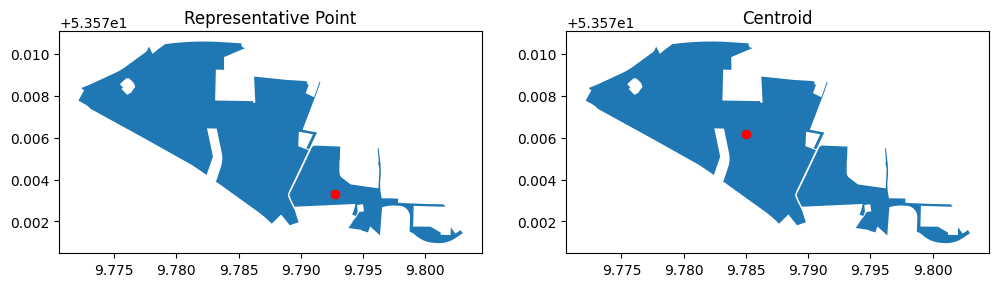

In [47]:
# Testing both alternatives
park_name = "Waldpark Marienhoehe"

def centroid_comparison(park_name):
    park_comparison_df = merged_parks_gdf.query(f'name == "{park_name}"')
    
    rep_comparison_df = park_comparison_df["representative_point"]
    centroid_comparison_df = park_comparison_df["centroid"]

    # Plotting of both alternatives for comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    park_comparison_df.plot(ax=axes[0])
    rep_comparison_df.plot(ax=axes[0], marker='o', color='red')

    park_comparison_df.plot(ax=axes[1])
    centroid_comparison_df.plot(ax=axes[1], marker='o', color='red')

    axes[0].set_title('Representative Point')
    axes[1].set_title('Centroid')

    plt.show()

centroid_comparison(park_name)

In [48]:
merged_parks_gdf.head()

,name,geometry,size,representative_point,centroid
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5...",1.6005,POINT (9.94847 53.56571),POINT (9.94810 53.56558)
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53...",27.2419,POINT (10.03659 53.63119),POINT (10.03683 53.63159)
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53...",13.7983,POINT (10.00115 53.57361),POINT (10.00090 53.57318)
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ...",7.9442,POINT (9.98665 53.55934),POINT (9.98664 53.55931)
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5...",5.0377,POINT (9.97118 53.54874),POINT (9.97132 53.54883)


In [62]:
park_size = merged_parks_gdf[['name','size']]
park_size_cluster = park_size.sort_values(by='size', ascending= False)
park_size_cluster['size_sqm'] = park_size_cluster['size']*10000
merged_parks_gdf.head()


,name,geometry,size,representative_point,centroid
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5...",1.6005,POINT (9.94847 53.56571),POINT (9.94810 53.56558)
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53...",27.2419,POINT (10.03659 53.63119),POINT (10.03683 53.63159)
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53...",13.7983,POINT (10.00115 53.57361),POINT (10.00090 53.57318)
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ...",7.9442,POINT (9.98665 53.55934),POINT (9.98664 53.55931)
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5...",5.0377,POINT (9.97118 53.54874),POINT (9.97132 53.54883)


In [50]:
park_size_cluster.dtypes

name         object
size        float64
size_sqm    float64
dtype: object

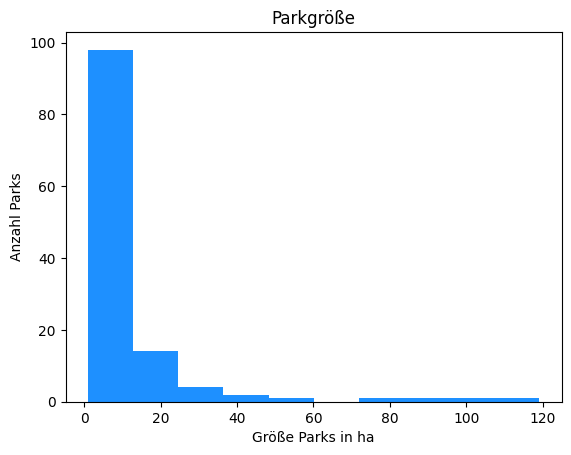

In [51]:
f, ax = plt.subplots(1,1)
plt.hist(park_size_cluster['size'],bins=10, color = 'dodgerblue')

ax.set_title('Parkgröße')
ax.set_xlabel('Größe Parks in ha')
ax.set_ylabel('Anzahl Parks')

plt.show()

In [74]:
conditions = [
    (merged_parks_gdf['size'] < 10.0),
    (merged_parks_gdf['size'] > 10.0) & (merged_parks_gdf['size'] <= 50.0),
    (merged_parks_gdf['size'] > 60.0)
]

values = ['500','1000','1500']

merged_parks_gdf['walk_dist'] = np.select(conditions,values)
merged_parks_gdf.head(50)

,name,geometry,size,representative_point,centroid,walk_dist
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5...",1.6005,POINT (9.94847 53.56571),POINT (9.94810 53.56558),500
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53...",27.2419,POINT (10.03659 53.63119),POINT (10.03683 53.63159),1000
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53...",13.7983,POINT (10.00115 53.57361),POINT (10.00090 53.57318),1000
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ...",7.9442,POINT (9.98665 53.55934),POINT (9.98664 53.55931),500
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5...",5.0377,POINT (9.97118 53.54874),POINT (9.97132 53.54883),500
5,Alter Friedhof Harburg,"POLYGON ((9.97987 53.45348, 9.97987 53.45348, ...",6.1387,POINT (9.98018 53.45563),POINT (9.98032 53.45574),500
6,Alter Friedhof Lohbruegge,"POLYGON ((10.20026 53.49901, 10.20074 53.49880...",2.0620,POINT (10.20011 53.49804),POINT (10.20008 53.49802),500
7,Altonaer Balkon,"POLYGON ((9.93560 53.54581, 9.93560 53.54581, ...",5.0674,POINT (9.93560 53.54550),POINT (9.93737 53.54538),500
8,Altonaer Volkspark,"MULTIPOLYGON (((9.90039 53.58102, 9.90029 53.5...",103.4407,POINT (9.89584 53.57926),POINT (9.89974 53.58057),1500
9,Amsinckpark,"POLYGON ((9.94468 53.60232, 9.94499 53.60214, ...",5.5485,POINT (9.94306 53.60118),POINT (9.94315 53.60136),500


In [11]:
park_coordinates = merged_parks_gdf[["name", "geometry"]]
park_coordinates.head()

,name,geometry
0,Alsenpark,"MULTIPOLYGON (((9.94658 53.56546, 9.94651 53.5..."
1,Alsterpark Klein Borstel,"MULTIPOLYGON (((10.02926 53.62631, 10.02915 53..."
2,Alstervorland,"MULTIPOLYGON (((10.00106 53.57307, 10.00103 53..."
3,Alter Botanischer Garten,"POLYGON ((9.98821 53.56079, 9.98915 53.56009, ..."
4,Alter Elbpark,"MULTIPOLYGON (((9.97090 53.54780, 9.97091 53.5..."


In [12]:
#park_coordinates.to_file('data.json', driver ='GeoJSON')